# NETWORK ANAMOLY DETECTION MODELS




Roji Augustine

roji.augustine@techmahindra.com

rojiaugustine@gmail.com

In [0]:
# importing required modules
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing, model_selection, neighbors, metrics
from sklearn.metrics import confusion_matrix
import pickle
import os



In [176]:
# mounting google drive to access the data files 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path = Path(root_dir + 'hackathon/')

Mounted at /content/gdrive


In [177]:
# enable scroll for output cell
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50000;

<IPython.core.display.Javascript object>

In [0]:
# defining the dictionary to map attack name to the attack category. eg : smurf belong to category DOS. This dictionary is used for model 2
dict_attack_to_category = {'normal' : 'normal','back': 'DOS', 'land': 'DOS', 'neptune': 'DOS', 'pod': 'DOS', 'smurf': 'DOS', 'teardrop': 'DOS', 'apache2': 'DOS', 'processtable': 'DOS', 'worm': 'DOS', 'udpstorm': 'DOS', 'mailbomb': 'DOS', 'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L', 'satan': 'PROBE', 'ipsweep': 'PROBE', 'portsweep': 'PROBE', 'nmap': 'PROBE', 'mscan': 'PROBE', 'saint': 'PROBE'}

##Method definitions

In [0]:
def neural_network(df,dep_var,cat_names,cont_names,epoch,learning_rate,procs,model_name=None):  
    '''
    To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''
    # calculating the train and test size of the data from test_percent
    train_size = int(len(df)-len(df) * test_percent)
    test_size =  int(len(df) * test_percent)
    print("Total Data Size {}, Train data size {}, Test Data size {}".format(len(df),train_size,test_size))
    
    test = TabularList.from_df(df.iloc[0:test_size].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

    data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                               .split_by_idx(list(range(0,test_size)))
                               .label_from_df(cols=dep_var)
                               .add_test(test)
                               .databunch())

    #  Neural network with two hidden fully connected layers of size 200 and 100 
    learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
    print("\nNumber of classes : {}".format(learn.data.c))
    print("The classes are : {}\n".format(learn.data.classes))

    learn.fit(epoch,learning_rate)
    interp = ClassificationInterpretation.from_learner(learn)

    # Actual , Predicted , number of times times
    print("\nMost confused items are below : Actual , Predicted , Number of times times \n")
    print(interp.most_confused())

    print("\nConfusion Matrix\n")
    interp.plot_confusion_matrix()
    
    # to save the model    
    if model_name:
        print("Saving model as {}".format(model_name))
        learn.export(model_name)     
       
        
def handle_non_numerical_data(df):
     '''
     To map non numerical values to numerical in the Pandas data frame

     Arguements
     df : Pandas data set contains train and test data

     '''
  
     columns = df.columns.values
   
     for column in columns:
          text_digit_vals = {}
          def convert_to_int(val):
               return text_digit_vals[val]

          if df[column].dtype != np.int64 and df[column].dtype != np.float64:
               column_contents = df[column].values.tolist()
               unique_elements = set(column_contents)
               x=0
               for unique in unique_elements:
                   if unique not in text_digit_vals:
                        text_digit_vals[unique] = x
                        x+=1
               df[column] = list(map(convert_to_int,df[column]))
     return df        


def random_forest(df,label,n_jobs,model_name=None):
    '''
    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''

    df = handle_non_numerical_data(df)
    X = np.array(df.drop([label],1))
    y = np.array(df[label])
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=test_percent)

    clf = RandomForestClassifier(n_jobs=n_jobs)
    clf.fit(df.drop(label, axis=1), df[label])

    accuracy=clf.score(X_test,y_test)
    prediction=clf.predict(np.array(X_test))
    
    print("Number of classes : {}".format(clf.n_classes_))
    print("The classes are : {}".format(clf.classes_))    
    
    #Confusion Matrix
    print("Confusion Matrix\n")
    confusion_matrix(y_test,prediction)

    #Compute Area Under the Curve (AUC) Metrics for Binary classification
    if clf.n_classes_ == 2:
        auc_metric = metrics.roc_auc_score(y_test, prediction)                         
        print("Accuracy : {}, AUC Metric : {}".format(accuracy,auc_metric))
    else:
        print("Accuracy : {}".format(accuracy))

    # to save the model    
    if model_name:
        print("Saving model as {}".format(model_name))
        with open(os.path.join(path,model_name),"wb") as f:
            pickle.dump(clf,f) 
    

def KNearest_neighbors(df,label,n_jobs,model_name=None):
    '''
    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''
  
    df = handle_non_numerical_data(df)
    X = np.array(df.drop([label],1))
    y = np.array(df[label])
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=test_percent)
    clf = neighbors.KNeighborsClassifier(n_jobs=n_jobs)
    clf.fit(X_train,y_train)
    accuracy=clf.score(X_test,y_test)
    prediction=clf.predict(np.array(X_test))

    print("Number of classes : {}".format(len(clf.classes_)))
    print("The classes are : {}".format(clf.classes_))      
          
    #Confusion Matrix
    print("Confusion Matrix\n")
    confusion_matrix(y_test,prediction)

    #Compute Area Under the Curve (AUC) Metrics for Binary classification
    if len(clf.classes_) == 2:
        auc_metric = metrics.roc_auc_score(y_test, prediction)                         
        print("Accuracy : {}, AUC Metric : {}".format(accuracy,auc_metric))
    else:
        print("Accuracy : {}".format(accuracy))

    # to save the model    
    if model_name:
        print("Saving model as {}".format(model_name))
        with open(os.path.join(path,model_name),"wb") as f:
            pickle.dump(clf,f) 

    


In [0]:
# 20% of data is used as testing data
test_percent = 0.2

# Column names for the test / train data
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
"dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]


Reading the test and train data into Pandas `DataFrame`.

In [0]:
# reading train data
df_train = pd.read_csv(path/'train.csv')
df_train.columns = columns

In [0]:
# reading test data
df_test = pd.read_csv(path/'test.csv')
df_test.columns = columns

In [0]:
# merging train and test dataset
df_test_train=pd.concat([df_train,df_test])

Dropping the last_flag column as this doesnt have any signifance 

In [184]:
# dropping the 'last_flag' column, which is not significant
df_test_train.drop(['last_flag'],axis = 1,inplace=True)
df_test_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


## We are going to create two models. For first model (Model 1), is for predicting only if it is attack or not. Second model (Model 2) will predict attack type, if there is a attack.




Making a copy of the original datafarme for this model

In [0]:
df1 = df_test_train.copy(deep = True)


### Adding another column attack_flag (label for model 1) :  some type of attack = 1, nomal = 0

In [0]:
# creating new column (label for model 1)
df1['attack_flag'] = df1['attack'].apply(lambda attack : attack if attack == 'normal' else 'attack') 

In [0]:
# removing the "attack" column as we have 'attack_flag' column already derived from "attack" column
df1.drop(['attack'],axis = 1,inplace=True)

In [0]:
dep_var = 'attack_flag'


# categorical features
cat_names = ["protocol_type", "service", "flag", "land", "logged_in", "root_shell", "su_attempted", "is_host_login","is_guest_login"]

# continuous features
cont_names = ["duration","src_bytes","dst_bytes",
"wrong_fragment","urgent","hot","num_failed_logins",
"num_compromised","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate"]

# preprocessing parameters
procs = [FillMissing, Categorify, Normalize]

### Model 1 : predicting if there is attack or not with neural network (Binomial Classification)

        To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    model_name : (Optional) : Model name, if the model needs to be saved


Most confused items are below : Actual , Predicted , Number of times times 

[('attack', 'normal', 273), ('normal', 'attack', 260)]

Confusion Matrix



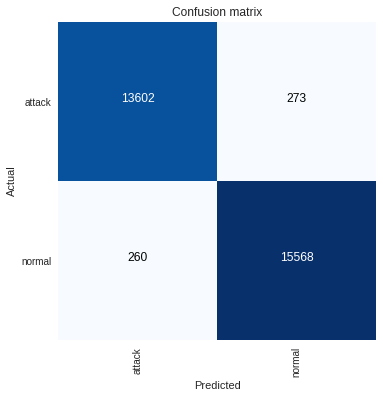

In [189]:
neural_network(df1,dep_var,cat_names,cont_names,2,1e-3,procs)

### Model 1 : predicting only if there is attack or not with Random Forest (Binomial Classification)

    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved


In [190]:
random_forest(df1,dep_var,-1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number of classes : 2
The classes are : [0 1]
Confusion Matrix

Accuracy : 0.9988216678449988, AUC Metric : 0.9988065169164295


### Model 1 : predicting only if there is attack or not with KNearest Neighbors (Binomial Classification)

    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    


In [191]:
KNearest_neighbors(df1,dep_var,-1)

Number of classes : 2
The classes are : [0 1]
Confusion Matrix

Accuracy : 0.991011008988991, AUC Metric : 0.9910172966232388


## Model 2 : predicting attack type - Activity is normal or DOS or PROBE or R2L or U2R etc  (Multinomial classification)

Making a copy of the original datafarme for this mode

In [0]:
df2 = df_test_train.copy(deep = True)

In [0]:
# creating label for Model 2
df2['attack_category'] = df2['attack'].apply(lambda attack : dict_attack_to_category[attack])

In [0]:
# created new label 'attack_category' for model 2. We dont require 'attack' column
df2.drop(['attack'],axis = 1,inplace=True)

In [0]:
dep_var = 'attack_category'

cat_names = ["protocol_type", "service", "flag", "land", "logged_in", "root_shell", "su_attempted", "is_host_login",
"is_guest_login"]


cont_names = ["duration","src_bytes","dst_bytes",
"wrong_fragment","urgent","hot","num_failed_logins",
"num_compromised","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate"]

# preprocessing parameters
procs = [FillMissing, Categorify, Normalize]


### Model 2 : predicting attack type (binomial classification) with neural network

    To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    model_name : (Optional) : Model name, if the model needs to be saved
    


Most confused items are below : Actual , Predicted , Number of times times 

[('DOS', 'normal', 123), ('normal', 'R2L', 103), ('R2L', 'normal', 53), ('PROBE', 'normal', 50), ('normal', 'U2R', 39), ('normal', 'PROBE', 26), ('U2R', 'normal', 8), ('normal', 'DOS', 8), ('U2R', 'R2L', 4), ('R2L', 'PROBE', 3), ('DOS', 'PROBE', 2), ('R2L', 'U2R', 2), ('DOS', 'R2L', 1), ('PROBE', 'DOS', 1), ('PROBE', 'R2L', 1), ('PROBE', 'U2R', 1)]

Confusion Matrix



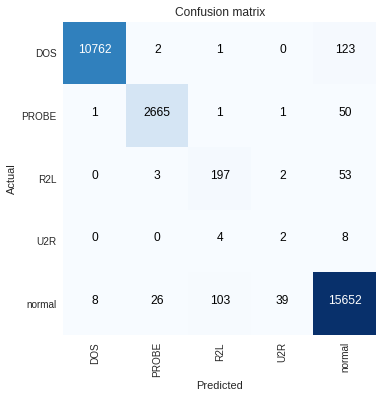

In [196]:
neural_network(df2,dep_var,cat_names,cont_names,2,1e-3,procs)

### Model 2 : predicting attack type (binomial classification) with Random Forest

    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    


In [197]:
random_forest(df2,dep_var,-1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number of classes : 5
The classes are : [0 1 2 3 4]
Confusion Matrix

Accuracy : 0.9991920008079992


### Model 2 : predicting attack type (binomial classification) with KNearest Neighbors

    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    



In [198]:
KNearest_neighbors(df2,dep_var,-1)

Number of classes : 5
The classes are : [0 1 2 3 4]
Confusion Matrix

Accuracy : 0.9886206780459886
